# Performance Evaluation

Evaluate OCT boundary estimation algorithms using the data set provided by [tia16].  

Note that we do *not* attempt any direct performance comparisons since the algorithms presented in the original paper did not have the benefit of training on this data set.  Numeric results should


### References
- [tia16] Tian et al. Performance evaluation of automated segmentation software on optical coherence tomography volume data. J. Biophotonics, 2016.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os, sys, time, glob

import pandas as pd

import numpy as np
import pylab as plt
from scipy.io import loadmat, savemat

import postproc_oct as poct

from IPython.display import display

print('Evaluated on:', time.strftime('%X %x %Z'))

Evaluated on: 10:46:16 09/19/17 EDT


# Functions/Structures for OCT Data


In [2]:
def tian_load_data(mat_file):
    """ Loads (a subset of the) data set from [tia16]. 
    
    Each patient has 5 images: one from fovea, 2 from para, and 2 from peri.
    These images appear to be ordered consecutively by patient (i.e. the
    first five images are for the first patient, the next 5 the second, etc.)
    
    However, it is not immediately obvious that the fovea/peri/para follow
    the same order within each patient.  There are some follow-on data 
    structures (see later in this cell) to help with this.
    """
    mf = loadmat(mat_file)
    all_algos = ['Spectralis', 'IOWA', 'Bern', 'AURA', 'OCTRIMA']
    print(mf.keys())
    
    # these functions map from original dimension ordering to something we prefer in python
    shuffle_algo = lambda x: np.transpose(x, [1,2,0])
    shuffle_miami = lambda x: np.transpose(x, [2,0,1])
    
    # Data and ground truth
    X =  shuffle_miami(mf['volumedata'])
    Y1 = shuffle_miami(mf['O1'])
    Y2 = shuffle_miami(mf['O2'])
    
    #---------------------------------------------------
    # Identify which subset of columns to evaluate
    #---------------------------------------------------
    mask = np.ones(Y1.shape[-1], dtype=np.bool)
    for algo in all_algos:
        Y_algo = shuffle_algo(mf[algo])
        is_valid = np.all(np.all(Y_algo >0, axis=0) >0, axis=0)
        mask = np.logical_and(mask, is_valid)
        
    print('feasibility mask admits %d columns' % np.sum(mask))
    plt.figure(); plt.plot(mask); plt.title('evaluation mask'); plt.ylim([-.01, 1.1]); plt.show()
           
    #---------------------------------------------------
    # Note that the number of surface annotations in O1/O2 is 9.
    # Table 2 in [tia16] lists 11 possible surfaces, so here
    # we determine which subset of O1/O2 has the 5 surfaces used
    # in the study.
    #---------------------------------------------------
    print('\nGround Truth Availability:')
    print('-'*80)
    for b_id in range(mf['O1'].shape[0]):
        y1 = mf['O1'][b_id,...]
        y2 = mf['O2'][b_id,...]
        print('boundary %d, O1/O2 median value:   %0.03f / %0.03f' % (b_id, np.median(y1.flatten()), np.median(y2.flatten())))
    print('-'*80 + '\n')
    
    boundaries_of_interest = np.array([0, 1, 2, 4, 7])  # via analysis above
    Y1 = Y1[:, boundaries_of_interest, :]
    Y2 = Y2[:, boundaries_of_interest, :]
    
    out = {}
    out['mask'] = mask
    out['X'] = X
    out['Y_O1'] = Y1
    out['Y_O2'] = Y2
    
    for algo in all_algos:
        out[algo] = shuffle_algo(mf[algo])
        #out[algo] = out[algo][..., mask]
    
    print('OCT images have shape: ', out['X'].shape)
    print('Truth has shape:       ', out['Y_O1'].shape)
    
    return out


def calc_err(tian, Y_hat):
    assert(all(Y_hat.shape) == tian['YO1'].shape)
    raise RuntimeError('todo')


# Here we map image indices to patient ids.
# Patient images seem to be consecutive (makes sense)
#
IMAGE_TO_PATIENT = { ii : np.floor(ii/5).astype(np.int32) for ii in range(50)}

# This data structure maps images to regions.
# These mappings do not appear to be stored in the matlab data structure, and were
# estimated by our domain experts.
# 
# Ref: Phil's email on august 17, 2017
#
FO = 'fovea'
PA = 'parafovea'
PE = 'perifovea'
IMAGE_TO_REGION = { 1 : FO,
                    2 : PA,
                    3 : PA,
                    4 : PE,
                    5 : PE,
                    6 : PE,
                    7 : PE,
                    8 : PA,
                    9 : PA,
                   10 : FO,
                   11 : PE, 
                   12 : PA, 
                   13 : FO,
                   14 : PA,
                   15 : PE, 
                   16 : PE,
                   17 : PA,
                   18 : FO,
                   19 : PA,
                   20 : PE,
                   21 : PE,
                   22 : PA,
                   23 : FO,
                   24 : PA,
                   25 : PE,
                   26 : PE,
                   27 : PA,
                   28 : FO,
                   29 : PA,
                   30 : PE,
                   31 : PA,
                   32 : FO,
                   33 : PA,
                   34 : PE,
                   35 : PE,
                   36 : PE,
                   37 : PA,
                   38 : FO,
                   39 : PA,
                   40 : PE,
                   41 : PA,
                   42 : FO,
                   43 : PA,
                   44 : PE,
                   45 : PE,
                   46 : PE,
                   47 : PA,
                   48 : FO,
                   49 : PA,
                   50 : PE}

# convert from numbering in email to 0-based idexing
IMAGE_TO_REGION = { x-1 : IMAGE_TO_REGION[x]  for x in IMAGE_TO_REGION.keys() }

print(IMAGE_TO_REGION)
print('')
print(IMAGE_TO_PATIENT)




{0: 'fovea', 1: 'parafovea', 2: 'parafovea', 3: 'perifovea', 4: 'perifovea', 5: 'perifovea', 6: 'perifovea', 7: 'parafovea', 8: 'parafovea', 9: 'fovea', 10: 'perifovea', 11: 'parafovea', 12: 'fovea', 13: 'parafovea', 14: 'perifovea', 15: 'perifovea', 16: 'parafovea', 17: 'fovea', 18: 'parafovea', 19: 'perifovea', 20: 'perifovea', 21: 'parafovea', 22: 'fovea', 23: 'parafovea', 24: 'perifovea', 25: 'perifovea', 26: 'parafovea', 27: 'fovea', 28: 'parafovea', 29: 'perifovea', 30: 'parafovea', 31: 'fovea', 32: 'parafovea', 33: 'perifovea', 34: 'perifovea', 35: 'perifovea', 36: 'parafovea', 37: 'fovea', 38: 'parafovea', 39: 'perifovea', 40: 'parafovea', 41: 'fovea', 42: 'parafovea', 43: 'perifovea', 44: 'perifovea', 45: 'perifovea', 46: 'parafovea', 47: 'fovea', 48: 'parafovea', 49: 'perifovea'}

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 2, 11: 2, 12: 2, 13: 2, 14: 2, 15: 3, 16: 3, 17: 3, 18: 3, 19: 3, 20: 4, 21: 4, 22: 4, 23: 4, 24: 4, 25: 5, 26: 5, 27: 5, 28: 5, 29: 

# Load Data

dict_keys(['__header__', 'O2', 'O1', 'Bern', 'OCTRIMA', 'volumedata', 'IOWA', '__globals__', 'Spectralis', 'AURA', '__version__'])
feasibility mask admits 442 columns


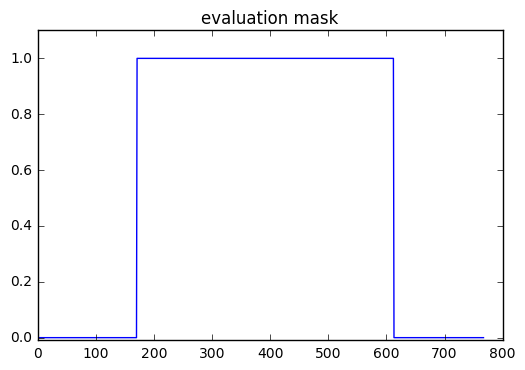


Ground Truth Availability:
--------------------------------------------------------------------------------
boundary 0, O1/O2 median value:   209.137 / 209.108
boundary 1, O1/O2 median value:   225.038 / 225.977
boundary 2, O1/O2 median value:   241.173 / 240.922
boundary 3, O1/O2 median value:   0.000 / 0.000
boundary 4, O1/O2 median value:   252.647 / 253.177
boundary 5, O1/O2 median value:   0.000 / 0.000
boundary 6, O1/O2 median value:   0.000 / 0.000
boundary 7, O1/O2 median value:   286.368 / 287.199
boundary 8, O1/O2 median value:   0.000 / 0.000
--------------------------------------------------------------------------------

OCT images have shape:  (50, 496, 768)
Truth has shape:        (50, 5, 768)
(50, 496, 768)
dict_keys(['AURA', 'Y_O2', 'Bern', 'OCTRIMA', 'mask', 'IOWA', 'X', 'Y_O1', 'Spectralis'])


In [3]:
#
# Load the data, ground truth, and OCT estimates from [tia16]
#
# NOTE: in section 3.3 of [tia16] the authors specify:
#   "Smaller unsigned error indicates the training data is closer to our
#    testing ground truth created by the Observer 1"
# Therefore, we use Y_O1 as ground truth in the remainder.
#
tian_fn = '/Users/pekalmj1/Data/Tian_OCT/jbio201500239-sup-0003-Data-S1.mat'

tian = tian_load_data(tian_fn)

print(tian['X'].shape)
print(tian.keys())

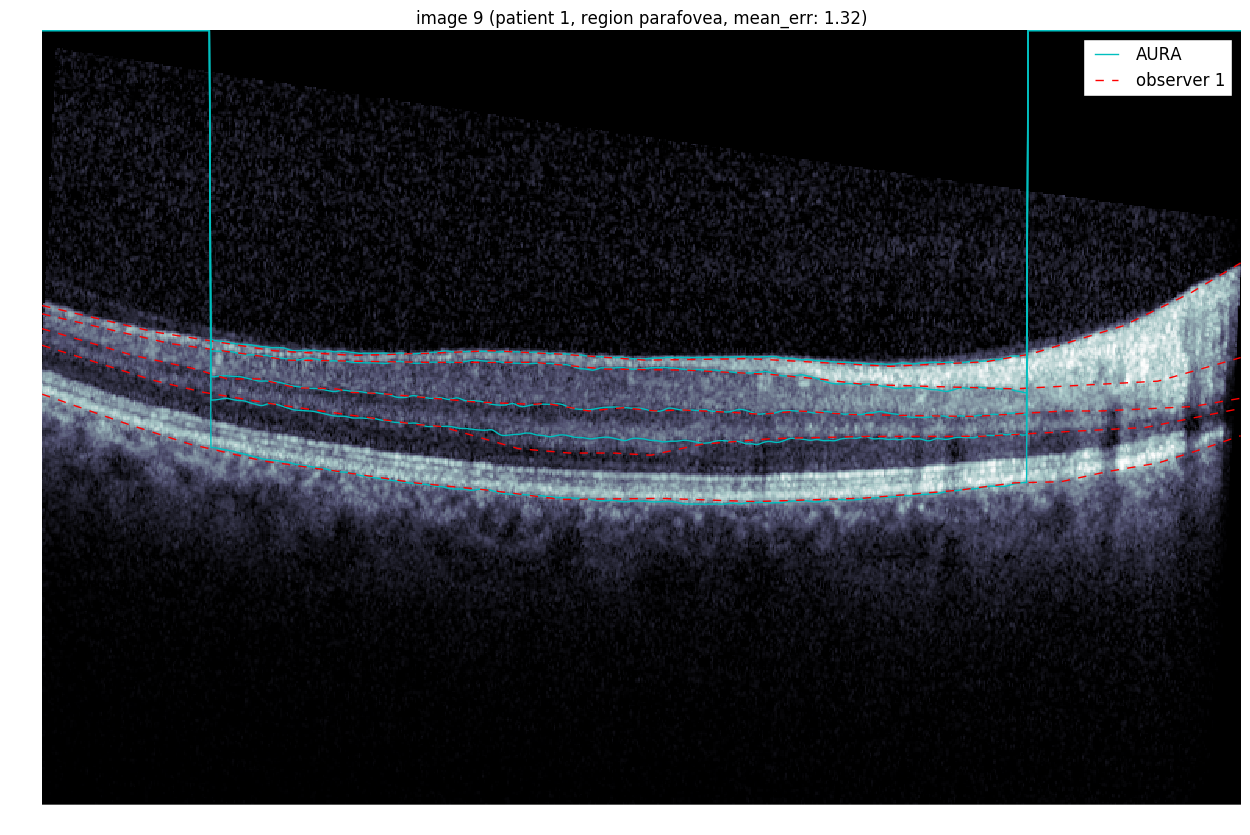

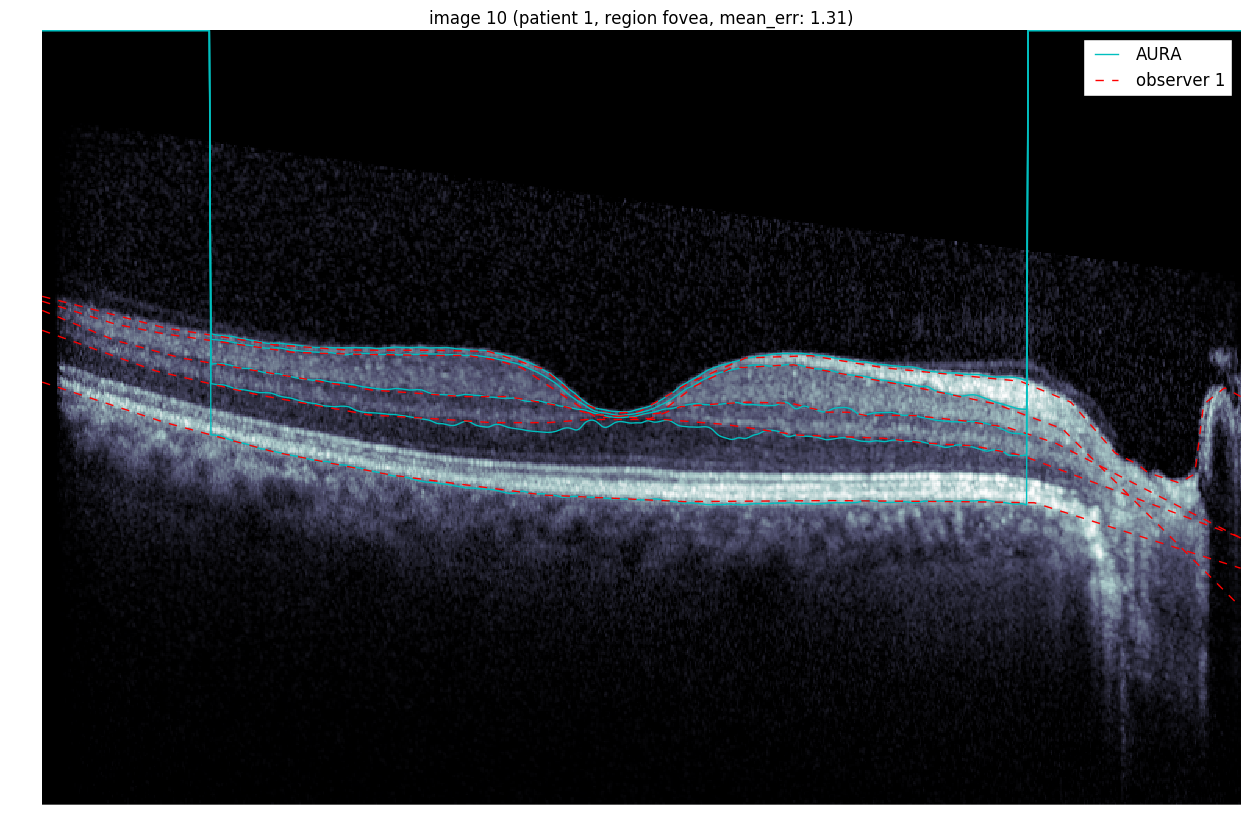

In [4]:
#------------------------------------------
# Visually inspect a subset of the data
#------------------------------------------
which_algo = 'AURA'

X = tian['X']
Y_true = tian['Y_O1']
Y_ref = tian[which_algo]


for img_idx in [8, 9]:
    plt.figure(figsize=(20,10))
    plt.imshow(X[img_idx,...], interpolation='none', cmap='bone')
    
    err = Y_true[img_idx, :, tian['mask']] - Y_ref[img_idx, :, tian['mask']]  # signed, per-pixel error
    mean_err = np.mean(np.abs(err)) 
    
    x_vals = np.arange(Y_true.shape[-1])

    for boundary_id in range(Y_true.shape[1]):
        plt.plot(x_vals, Y_ref[img_idx, boundary_id, :], '-c', label=which_algo)
        plt.plot(x_vals, Y_true[img_idx, boundary_id, :], '--r', label='observer 1')
        if boundary_id == 0: 
            plt.legend()

    plt.axis('off')
    plt.xlim([0, np.max(x_vals)])
    plt.ylim([0, X.shape[1]])
    plt.gca().invert_yaxis()
    
    plt.title('image %d (patient %d, region %s, mean_err: %0.2f)' % (img_idx+1, IMAGE_TO_PATIENT[img_idx], IMAGE_TO_REGION[img_idx], mean_err))
    

(50, 512, 768)


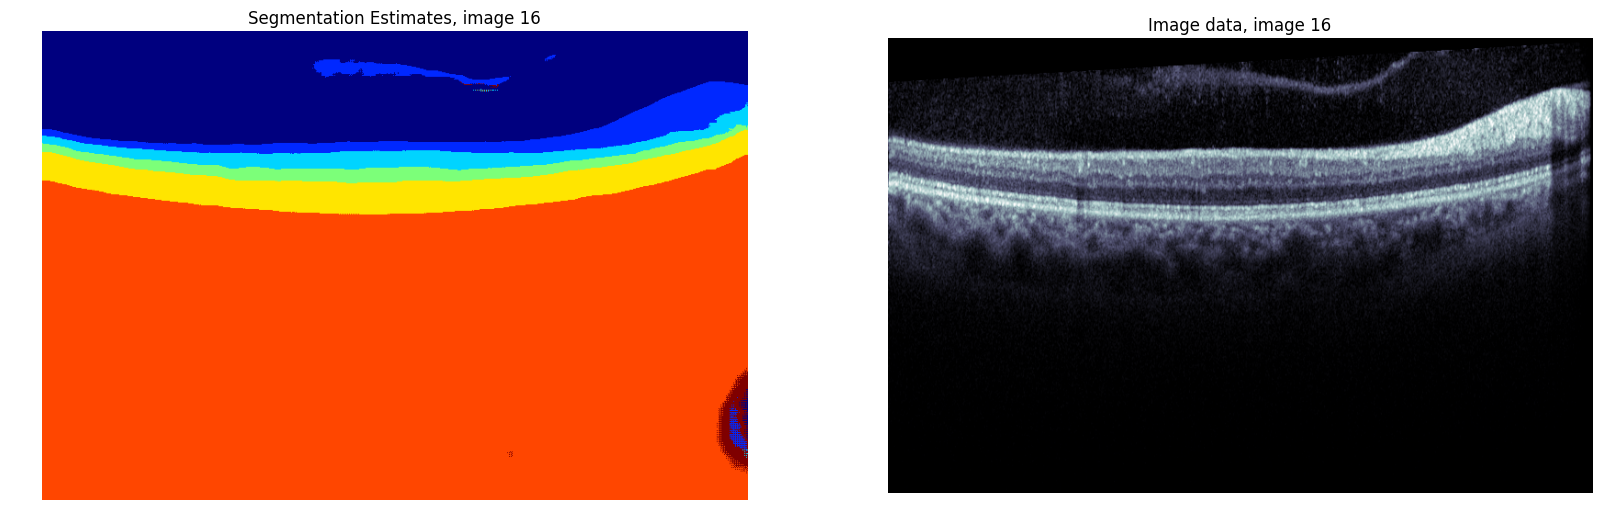

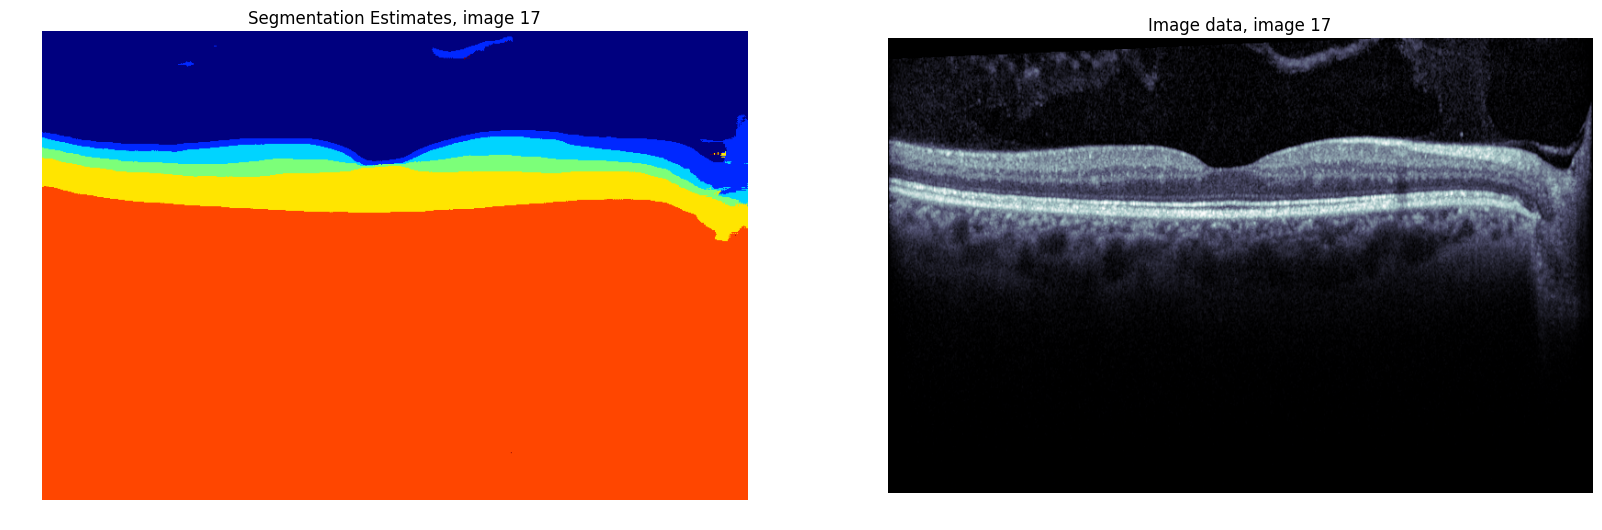

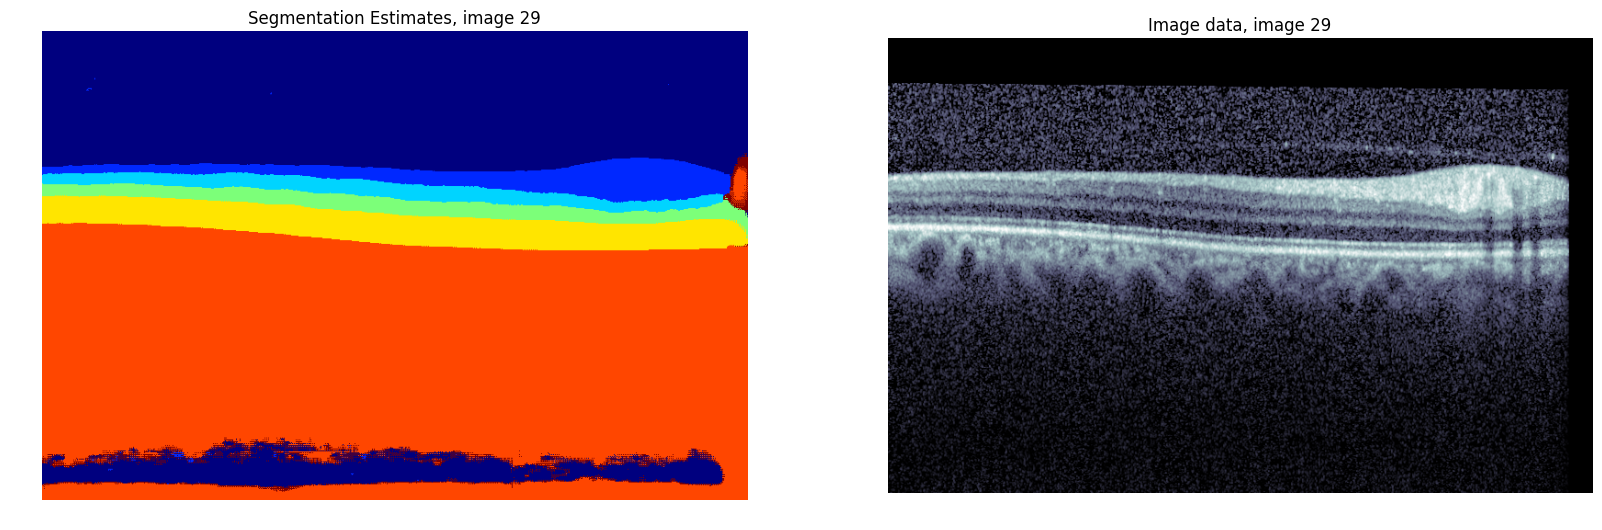

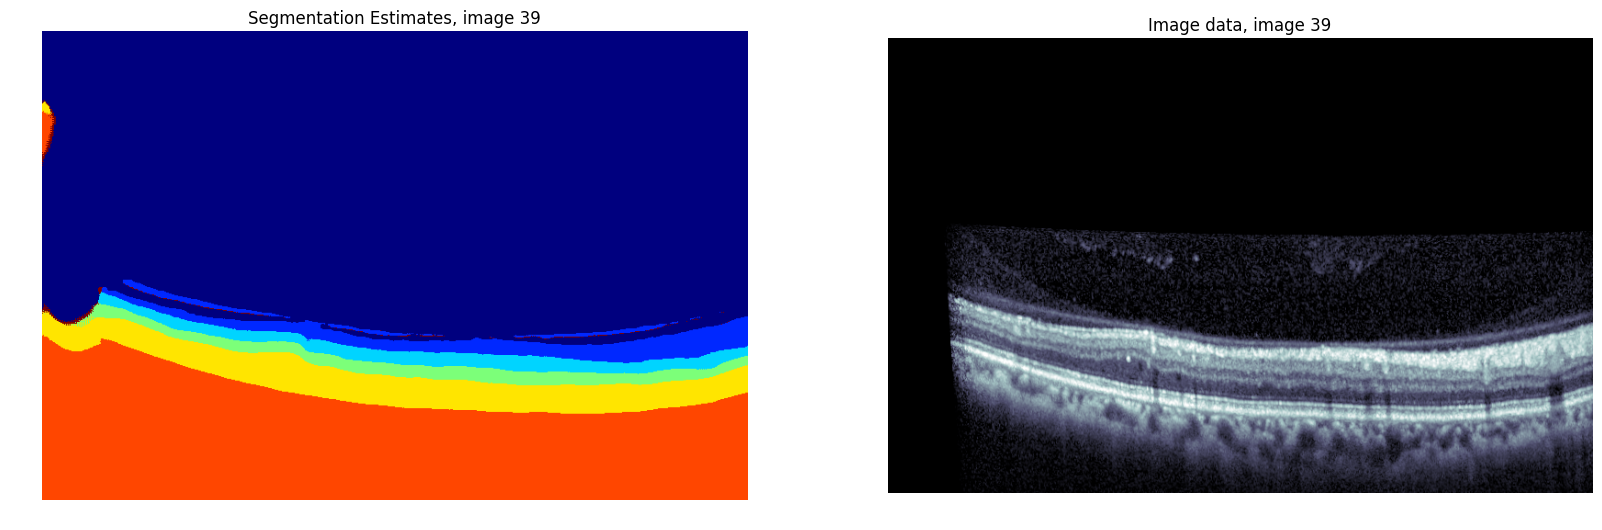

In [5]:
#----------------------------------------
# Load the raw segmentation estimates
#----------------------------------------

data_dir = './DenseNetFCN_Y_ensemble_results_kfold'
fold_files = glob.glob(os.path.join(data_dir, '*npz'))
fold_files.sort()  # use lexigraphic ordering to keep images/patients in order
y_hat_all = []
for fn in fold_files:
    y_hat_all.append(np.load(fn)['Y_hat_ensemble_mean'])
    
Y_hat_CNN = np.concatenate(y_hat_all, axis=0)
print(Y_hat_CNN.shape)


#----------------------------------------
# Visualize
#----------------------------------------
for img_idx in [16, 17, 29, 39]:
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.imshow(Y_hat_CNN[img_idx,:,:], interpolation=None)
    plt.axis('off')
    plt.title('Segmentation Estimates, image %d' % img_idx)
    #
    plt.subplot(1,2,2)
    plt.imshow(tian['X'][img_idx,...], interpolation=None, cmap='bone')
    plt.axis('off')
    plt.title('Image data, image %d' % img_idx)
plt.show()

In [17]:
#----------------------------------------
# Generate explicit boundary estimates
#----------------------------------------

# we use NaN as a default value (rather than 0) so that,
# when we compute means, we can effectively ignore missing data 
# (ie. images we haven't processed yet).
surf_est_raw = np.nan * np.ones(tian['Y_O1'].shape)
surf_est_int = np.nan * np.ones(tian['Y_O1'].shape)

eval_cols = np.sort(np.nonzero(tian['mask'])[0])
n_images = Y_hat_CNN.shape[0]

for img_idx in range(n_images):
    print(img_idx) # TEMP
    # special case processing for boundary 0 (more noise in that class est.)
    rows1, cols1 = poct.get_class_transitions(Y_hat_CNN[img_idx, :, :], 1, dedup=True)
    rows0, cols0 = poct.get_class_transitions(Y_hat_CNN[img_idx, :, :], 0, dedup=False)
    cols0, rows0 = poct.deduplicate_nn(cols0, rows0, cols1, rows1)
    surf_est_raw[img_idx, 0, cols0] = rows0
    
    # the other surfaces are a bit cleaner
    for b_id in range(1,5):
        rows, cols = poct.get_class_transitions(Y_hat_CNN[img_idx, :, :], b_id, dedup=True)  
        surf_est_raw[img_idx, b_id, cols] = rows
    
        # boundaries from CNN + regression
        # TODO: build this directly from transitions calculated above...
        b_est = poct.estimate_boundary(Y_hat_CNN[..., eval_cols], b_id, poct.boundary_regression_1d, interp_only=False)
        surf_est_int[:, b_id, eval_cols] = b_est
    

#------------------------------    
# Visualize    
#------------------------------
for img_idx in range(n_images):
    
    # for now, we just want to look at images with issues in surface 0
    y_hat_raw_0 = surf_est_raw[img_idx,0,eval_cols]
    y_hat_int_0 = surf_est_int[img_idx,0,eval_cols]
    y_true_0 = tian['Y_O1'][img_idx,0,eval_cols]
    
    err = np.nanmean(np.abs(y_hat_raw_0 - y_true_0))
    if err <= 2:
        continue
    
    plt.figure(figsize=(20,10))
    plt.imshow(tian['X'][img_idx,...], interpolation='none', cmap='bone')
    for b_id in range(5):
        plt.plot(surf_est_raw[img_idx,b_id,:], 'c-')
        plt.plot(surf_est_int[img_idx,b_id,:], 'b-')
        plt.plot(tian['Y_O1'][img_idx,b_id,:], 'm--')
    plt.xlim([0, tian['X'].shape[-1]])
    plt.ylim([0, tian['X'].shape[-2]])
    plt.gca().invert_yaxis()
    plt.title('image %d (s0 error: %0.3f)' % (img_idx, err))
    
    plt.show()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


# Error Analysis

## Per-region errors
Examine surface estimation errors for various regions of the eye.

In [18]:
def mean_error(Y_true, Y_other, surface_id, region_id):
    """Computes boundary estimation error (in pixels).
    As was done in table 5 of [tia16] we compute these errors on a per-surface basis.
    """
    n_images = Y_true.shape[0]
    which_images = [x for x in range(n_images) if region_id == IMAGE_TO_REGION[x]]    
    err = Y_true[which_images, surface_id, :] - Y_other[which_images, surface_id, :]
    
    mu_s = np.nanmean(err)
    mu_u = np.nanmean(np.abs(err))
    return mu_u, mu_s
       
    
# just to simplify subsequent code, add our estimates to the overall collection from Tian et al.
tian['APL_RAW'] = surf_est_raw
tian['APL_INT'] = surf_est_int

eval_cols = np.sort(np.nonzero(tian['mask'])[0])
eval_algos = ['APL_RAW', 'APL_INT', 'Spectralis', 'OCTRIMA', 'AURA', 'IOWA', 'Bern', 'Y_O2']

rows = []
Errors_u = np.zeros((5*3, len(eval_algos)))
Errors_s = np.zeros((5*3, len(eval_algos)))

for surface in np.arange(5):
    for region in [FO, PA, PE]:
        rows.append('s%d-%s' % (surface, region))
              
        for algo_idx, algo in enumerate(eval_algos):
            err_u, err_s = mean_error(tian['Y_O1'][..., eval_cols], 
                                      tian[algo][..., eval_cols], 
                                      surface, region)
            Errors_s[len(rows)-1, algo_idx] = err_s
            Errors_u[len(rows)-1, algo_idx] = err_u


with pd.option_context('display.max_columns', 10):
    df = pd.DataFrame(data=Errors_u, index=rows, columns=eval_algos)
    print('unsigned error:')
    display(df)
    
    df = pd.DataFrame(data=Errors_s, index=rows, columns=eval_algos)
    print('signed error:')
    display(df)


unsigned error:


 /Users/pekalmj1/anaconda3/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning:Mean of empty slice
 /Users/pekalmj1/anaconda3/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning:Mean of empty slice


APL_RAW   APL_INT  Spectralis   OCTRIMA      AURA      IOWA  \
s0-fovea      1.164630       NaN    0.899527  0.899412  0.898212  2.144169   
s0-parafovea  1.114489       NaN    1.139318  0.999078  1.312004  1.979259   
s0-perifovea  1.118554       NaN    1.127006  0.917513  1.620318  2.013922   
s1-fovea      1.244777  1.246366    1.390312  1.154609  1.288789  2.420166   
s1-parafovea  1.026678  0.977746    0.915069  1.034952  0.923049  1.592916   
s1-perifovea  1.152421  1.069449    2.019381  1.349877  1.417596  1.536518   
s2-fovea      1.013317  1.075224    1.302011  1.121823  1.252355  1.810096   
s2-parafovea  0.907576  0.884495    1.319532  0.911423  1.020665  1.670965   
s2-perifovea  0.916256  0.880589    2.824011  1.003039  1.142313  1.890992   
s3-fovea      1.452232  1.412154    1.791650  2.745563  2.584646  1.576353   
s3-parafovea  1.254652  1.221023    1.095834  1.357209  1.418183  1.503104   
s3-perifovea  1.084101  1.050506    0.987382  1.078872  1.140600  1.486423   
s4-fovea      0.923987  0.872346    0.812605  1.022292  0.878657  1.081163   
s4-parafovea  1.065406  1.034908    0.984737  1.189336  0.950667  1.136246   
s4-perifovea  1.114407  1.081633    1.074189  1.306769  1.017271  1.380120   

                  Bern      Y_O2  
s0-fovea      1.672877  0.851125  
s0-parafovea  1.809274  0.888439  
s0-perifovea  1.619807  0.857656  
s1-fovea      2.021043  1.309528  
s1-parafovea  2.446424  0.965650  
s1-perifovea  3.465173  1.220267  
s2-fovea      1.438839  1.126533  
s2-parafovea  1.520584  1.082852  
s2-perifovea  1.755766  1.112231  
s3-fovea      1.857448  1.499367  
s3-parafovea  1.742488  1.362238  
s3-perifovea  1.620855  1.114560  
s4-fovea      1.234614  1.117626  
s4-parafovea  1.155125  1.120159  
s4-perifovea  1.315721  1.109424

signed error:


APL_RAW   APL_INT  Spectralis   OCTRIMA      AURA      IOWA  \
s0-fovea      1.026994       NaN   -0.492867  0.742099  0.759444  2.132359   
s0-parafovea  0.860366       NaN   -0.911843  0.688770  1.161277  1.948395   
s0-perifovea  0.835909       NaN   -0.891788  0.593004  1.507645  1.962058   
s1-fovea     -0.548460 -0.541846    0.360271  0.171923  0.773987  2.009253   
s1-parafovea -0.365929 -0.370666    0.471175  0.356922  0.136404  1.410542   
s1-perifovea  0.286842  0.285591    1.246340 -0.042065  0.325514  1.248094   
s2-fovea      0.125434  0.250098    0.268139 -0.299835 -0.010902  1.494383   
s2-parafovea  0.134573  0.134235    0.775919 -0.018703  0.247873  1.459912   
s2-perifovea  0.181158  0.180419    2.674710  0.457699  0.777544  1.769393   
s3-fovea     -0.545380 -0.545371   -1.387009 -2.433783 -2.122673  0.194213   
s3-parafovea -0.112506 -0.111348   -0.419224 -0.825209 -0.147674  0.788016   
s3-perifovea -0.368677 -0.369515   -0.154197 -0.252605 -0.062161  1.072161   
s4-fovea     -0.487421 -0.487906   -0.336403 -0.794435 -0.624300  0.908733   
s4-parafovea -0.733505 -0.734157   -0.472985 -0.988482 -0.615594  0.958803   
s4-perifovea -0.679701 -0.680601   -0.464882 -0.975968 -0.521938  1.197335   

                  Bern      Y_O2  
s0-fovea      1.640277  0.360261  
s0-parafovea  1.757219  0.174423  
s0-perifovea  1.553800  0.296011  
s1-fovea      1.516267  0.647258  
s1-parafovea  2.251944  0.169596  
s1-perifovea  3.311668  0.221008  
s2-fovea      1.067234  0.029715  
s2-parafovea  1.217265  0.172572  
s2-perifovea  1.507176  0.539551  
s3-fovea      0.249416 -0.205496  
s3-parafovea  1.392994  0.221210  
s3-perifovea  1.301459  0.107029  
s4-fovea      0.932715 -0.755337  
s4-parafovea  0.815364 -0.824451  
s4-perifovea  0.955932 -0.533500